In [1]:
import pandas as pd
import random
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels
import lxml
import statistics

from math import floor
from termcolor import colored as cl
from datetime import date
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import style
from matplotlib import rcParams

In [2]:
#Get list of all S&P 500 tickers:

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)
    sp500_df = table[0]
    tickers = sp500_df['Symbol'].tolist()
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    return tickers

sp500_tickers = get_sp500_tickers()

In [26]:
#Create random sample of 51 S&P 500 tickers:

tickers = random.sample(sp500_tickers, 51)
print(tickers)

['ENPH', 'CTSH', 'STX', 'CHRW', 'NXPI', 'LVS', 'PGR', 'KEYS', 'ADI', 'CRM', 'BDX', 'BG', 'AJG', 'FCX', 'DVN', 'VZ', 'PPL', 'DXCM', 'LII', 'BSX', 'ETN', 'FANG', 'MTCH', 'ADM', 'TAP', 'CMG', 'LULU', 'PSA', 'GPN', 'ITW', 'MAS', 'JBL', 'GIS', 'ARE', 'MCO', 'AWK', 'USB', 'NOC', 'HOLX', 'CSCO', 'MKC', 'CBOE', 'NWS', 'PRU', 'TTWO', 'CEG', 'STZ', 'COR', 'EFX', 'RCL', 'TRGP']


In [33]:
#Create ticker dictionary with hourly returns calculation
returns_dict = {}

def get_historical_data(tickers):
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        hist = stock.history(start="2024-01-01", end=date.today(), interval = '1h')
        if hist.empty:
            print(f"No data for {ticker}")
            continue
        hist = hist.dropna(subset=['Close'])
        if len(hist) > 0:
            hist['Returns'] = (hist['Close'] - hist['Close'].iloc[0]) / hist['Close'].iloc[0]
            returns_dict[ticker] = hist
        else:
            print(f"Warning: No valid data left for {ticker} after cleaning!")

get_historical_data(tickers)

In [28]:
#Filter tickers with IPO date after cutpoint:

count_values = []

for key, value in returns_dict.items():
    count = len(value)
    count_values.append(count)

filtered_dict = {k: v for k, v in returns_dict.items() if len(v) == statistics.mode(count_values)}

def collect_returns_dict(df_dict):
    return {
        name: df['Returns'].tolist() if 'Returns' in df.columns else []
        for name, df in filtered_dict.items()
    }

rets = collect_returns_dict(filtered_dict)

In [29]:
#Create dataframe and index:

rets_df = pd.DataFrame(rets).dropna()
aapl = yf.Ticker('AAPL')
dates = aapl.history(start="2024-01-01", end=date.today(), interval = '1h')
dates = dates.reset_index()
rets_df.index = dates['Datetime']
print(rets_df)

                               ENPH      CTSH       STX      CHRW      NXPI  \
Datetime                                                                      
2024-01-02 09:30:00-05:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2024-01-02 10:30:00-05:00 -0.004195  0.006343 -0.001684 -0.003551 -0.002970   
2024-01-02 11:30:00-05:00 -0.004603  0.004993  0.001203 -0.000458 -0.003684   
2024-01-02 12:30:00-05:00 -0.004009  0.002834  0.001444 -0.001603 -0.004689   
2024-01-02 13:30:00-05:00 -0.016053  0.003104 -0.001203 -0.000057 -0.008128   
...                             ...       ...       ...       ...       ...   
2025-07-30 11:30:00-04:00 -0.749443  0.008232  0.738602  0.127362  0.000759   
2025-07-30 12:30:00-04:00 -0.745880  0.004453  0.755684  0.125759  0.001474   
2025-07-30 13:30:00-04:00 -0.749258 -0.001754  0.775893  0.124957  0.000368   
2025-07-30 14:30:00-04:00 -0.753155 -0.012955  0.766727  0.113046 -0.013978   
2025-07-30 15:30:00-04:00 -0.752116 -0.007422  0.773

C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-st

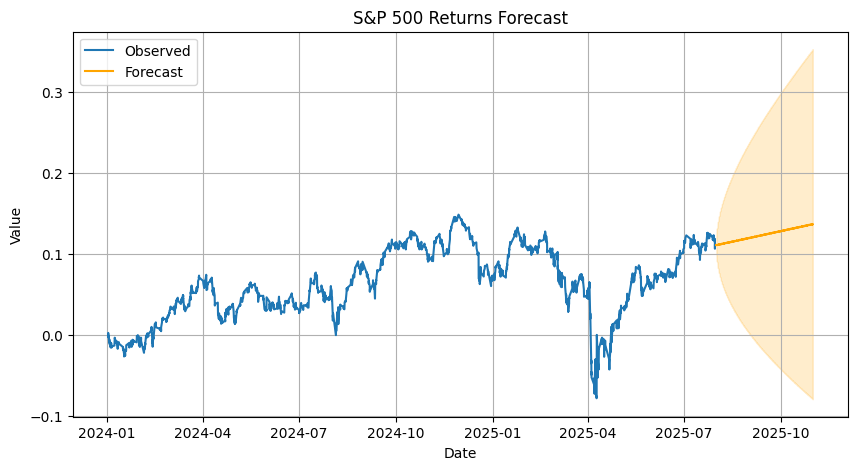

In [30]:
#Forecast future returns values of portfolio:

model = SARIMAX(rets_df.mean(axis=1), order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()

forecast = model_fit.get_forecast(steps=644)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

last_date = rets_df.mean(axis=1).index[-1]

daily_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=92, freq='D')

forecast_index = pd.DatetimeIndex([
    day + pd.Timedelta(hours=h)
    for day in daily_dates
    for h in range(9, 16)
])

forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# Plot
plt.figure(figsize=(10, 5))
plt.plot(rets_df.mean(axis=1), label='Observed')  # ✅ Fixed line
plt.plot(forecast_mean, label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.2)
plt.legend()
plt.title('S&P 500 Returns Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [31]:
#Calculate r for each ticker, and overall portfolio

rets_corr = rets_df.corr()
print("Average r by ticker:")
print(rets_corr.mean().sort_values(ascending = True))
print("Overall portfolio r:", rets_corr.values.mean())

Average r by ticker:
DXCM   -0.122247
LULU   -0.058020
TAP    -0.034476
COR    -0.032803
ENPH   -0.029508
DVN    -0.020856
BG     -0.018637
TTWO   -0.001718
ADM     0.006166
STZ     0.008836
GPN     0.024272
JBL     0.039380
ARE     0.040318
AWK     0.043094
BDX     0.044988
AJG     0.070218
NXPI    0.072476
FANG    0.077578
GIS     0.077754
VZ      0.079080
BSX     0.093202
CBOE    0.096124
FCX     0.097254
CSCO    0.099415
PPL     0.110562
NWS     0.115157
MTCH    0.116631
LVS     0.133081
CMG     0.135581
HOLX    0.137162
NOC     0.140300
STX     0.143807
CTSH    0.153990
CEG     0.158394
TRGP    0.160655
CRM     0.163390
KEYS    0.186023
MKC     0.186200
ADI     0.190373
EFX     0.196994
CHRW    0.209580
MCO     0.210543
ETN     0.217328
ITW     0.221327
LII     0.226040
PSA     0.227349
PRU     0.230203
MAS     0.248455
USB     0.276090
dtype: float64
Overall portfolio r: 0.10504300053696443


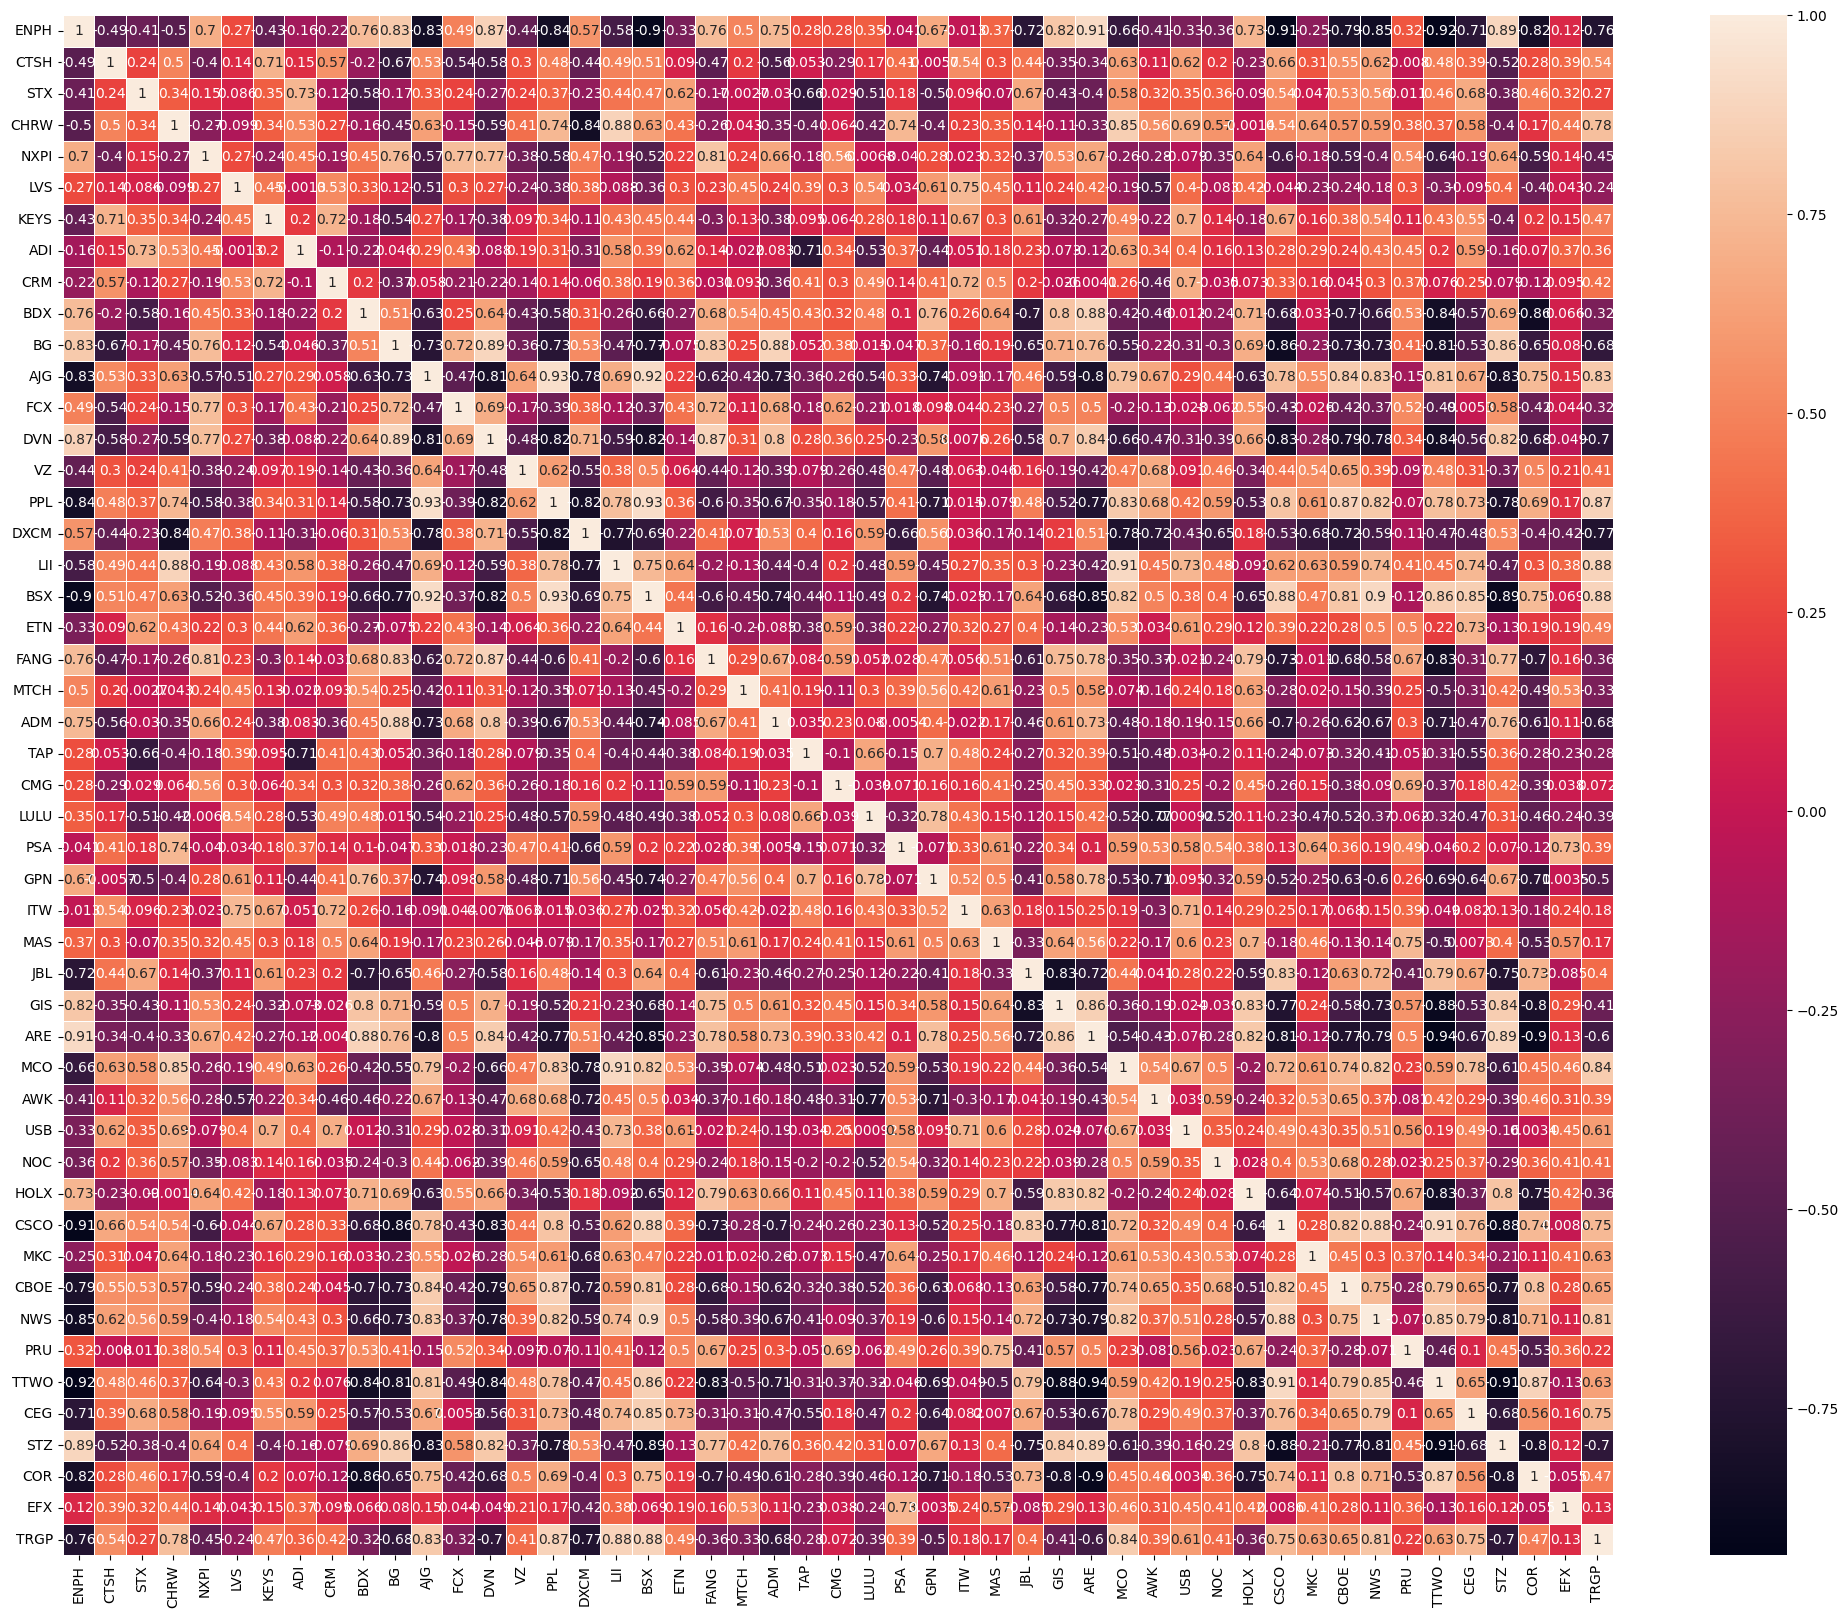

In [32]:
#View correlation matrix of returns between each ticker

plt.style.use('default')
plt.figure(figsize=(25,20))
sns.heatmap(rets_corr, annot = True, linewidths = 0.5) 
plt.show()